# Hand Written Digit Classification
## Using SGD Optimizer in LeNet

Template below is taken from [Course's Github repo](https://github.com/iitkliv/ai61002_Spr2020/blob/master/Tutorial4_Training_LeNet_using_GD.ipynb)

### Importing Libraries

In [1]:
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torch.optim as optim

### Load data

In [2]:
apply_transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor()])
BatchSize = 128 # change according to system specs

trainset = datasets.MNIST(root='./MNIST', train=True, download=True, transform=apply_transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

# Validation set with random rotations in the range [-90,90]
testset = datasets.MNIST(root='./MNIST', train=False, download=True, transform=apply_transform)
testLoader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader

In [3]:
# Size of train and test datasets
print('No. of samples in train set: '+str(len(trainLoader.dataset)))
print('No. of samples in test set: '+str(len(testLoader.dataset)))

No. of samples in train set: 60000
No. of samples in test set: 10000


### Define model architecture

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)        
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

In [5]:
use_gpu = torch.cuda.is_available()
net = LeNet()
print(net)
if use_gpu:
    print('GPU is avaialble!')
    net = net.cuda()

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
GPU is avaialble!


### Train model

In [6]:
criterion = nn.CrossEntropyLoss() 
learning_rate = 0.0005
optimizer = optim.SGD(net.parameters(), lr=learning_rate)
num_epochs = 100

train_loss = []
train_acc = []
for epoch in range(num_epochs):
    running_loss = 0.0 
    running_corr = 0
    
    for i,data in enumerate(trainLoader):
        
        inputs,labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(),labels.cuda() 
        # Initializing model gradients to zero
        # optimizer.zero_grad()
        # Both optimizer.zero_grad() and net.zero_grad() works the same
        # See: https://discuss.pytorch.org/t/model-zero-grad-or-optimizer-zero-grad/28426/4
        net.zero_grad() 
        # Data feed-forward through the network
        outputs = net(inputs)
        # Predicted class is the one with maximum probability
        preds = torch.argmax(outputs,dim=1)
        # Finding the loss
        loss = criterion(outputs, labels)
        # Accumulating the loss for each batch
        running_loss += loss 
        # Accumulate number of correct predictions
        running_corr += torch.sum(preds==labels)  
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss.item()/(i+1)   #Total loss for one epoch
    epoch_acc = running_corr.item()/60000
    
    
         
    train_loss.append(epoch_loss) #Saving the loss over epochs for plotting the graph
    train_acc.append(epoch_acc) #Saving the accuracy over epochs for plotting the graph
       
        
    print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(epoch+1,num_epochs,epoch_loss,epoch_acc*100))              

Epoch 1/100 : Training loss: 2.3051 | Training Accuracy: 10.2233
Epoch 2/100 : Training loss: 2.3043 | Training Accuracy: 10.2183
Epoch 3/100 : Training loss: 2.3036 | Training Accuracy: 10.2167
Epoch 4/100 : Training loss: 2.3029 | Training Accuracy: 10.2183
Epoch 5/100 : Training loss: 2.3022 | Training Accuracy: 10.2183
Epoch 6/100 : Training loss: 2.3015 | Training Accuracy: 10.2183
Epoch 7/100 : Training loss: 2.3008 | Training Accuracy: 10.2183
Epoch 8/100 : Training loss: 2.3001 | Training Accuracy: 10.2150
Epoch 9/100 : Training loss: 2.2994 | Training Accuracy: 10.2083
Epoch 10/100 : Training loss: 2.2987 | Training Accuracy: 10.1850
Epoch 11/100 : Training loss: 2.2980 | Training Accuracy: 10.1283
Epoch 12/100 : Training loss: 2.2972 | Training Accuracy: 10.1117
Epoch 13/100 : Training loss: 2.2964 | Training Accuracy: 10.9633
Epoch 14/100 : Training loss: 2.2955 | Training Accuracy: 13.6150
Epoch 15/100 : Training loss: 2.2946 | Training Accuracy: 17.6550
Epoch 16/100 : Trai

Text(0, 0.5, 'Training')

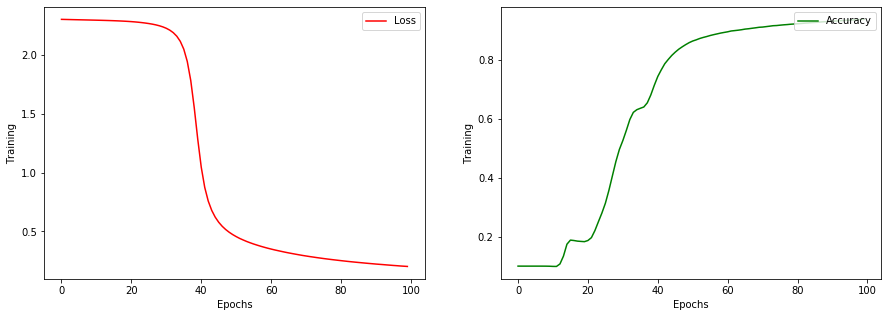

In [7]:
# Plotting 2 grahs, Training loss vs epochs and gtraining accuracy vs epochs
fig = plt.figure(figsize=[15,5]) 
plt.subplot(121)
plt.plot(range(num_epochs),train_loss,'r-',label='Loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')
plt.subplot(122)
plt.plot(range(num_epochs),train_acc,'g-',label='Accuracy') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')

### Evaluation of trained model

In [8]:
# Calculating testing accuracy
correct_pred = 0
for data in testLoader:
    inputs,labels = data
    if use_gpu:
        inputs, labels = inputs.cuda(),labels.cuda()
    # Feedforward train data batch through model
    output = net(inputs) 
    # Predicted class is the one with maximum probability
    preds = torch.argmax(output,dim=1)
    correct_pred += torch.sum(preds==labels)

test_accuracy = correct_pred.item()/10000.0
print('Testing accuracy = ',test_accuracy*100)

Testing accuracy =  94.37


## Training Error/Accuracy vs Epochs with different batch sizes and fixed learning rate

Batch size: 64
Epoch 1/50 : Training loss: 2.3025 | Training Accuracy: 9.8550
Epoch 2/50 : Training loss: 2.3018 | Training Accuracy: 10.0833
Epoch 3/50 : Training loss: 2.3012 | Training Accuracy: 10.1917
Epoch 4/50 : Training loss: 2.3005 | Training Accuracy: 11.1233
Epoch 5/50 : Training loss: 2.2999 | Training Accuracy: 11.8733
Epoch 6/50 : Training loss: 2.2992 | Training Accuracy: 10.6017
Epoch 7/50 : Training loss: 2.2984 | Training Accuracy: 12.5950
Epoch 8/50 : Training loss: 2.2975 | Training Accuracy: 11.9933
Epoch 9/50 : Training loss: 2.2964 | Training Accuracy: 11.7517
Epoch 10/50 : Training loss: 2.2953 | Training Accuracy: 11.9883
Epoch 11/50 : Training loss: 2.2939 | Training Accuracy: 12.4900
Epoch 12/50 : Training loss: 2.2923 | Training Accuracy: 13.3850
Epoch 13/50 : Training loss: 2.2904 | Training Accuracy: 14.7500
Epoch 14/50 : Training loss: 2.2880 | Training Accuracy: 16.4717
Epoch 15/50 : Training loss: 2.2849 | Training Accuracy: 18.8217
Epoch 16/50 : Traini

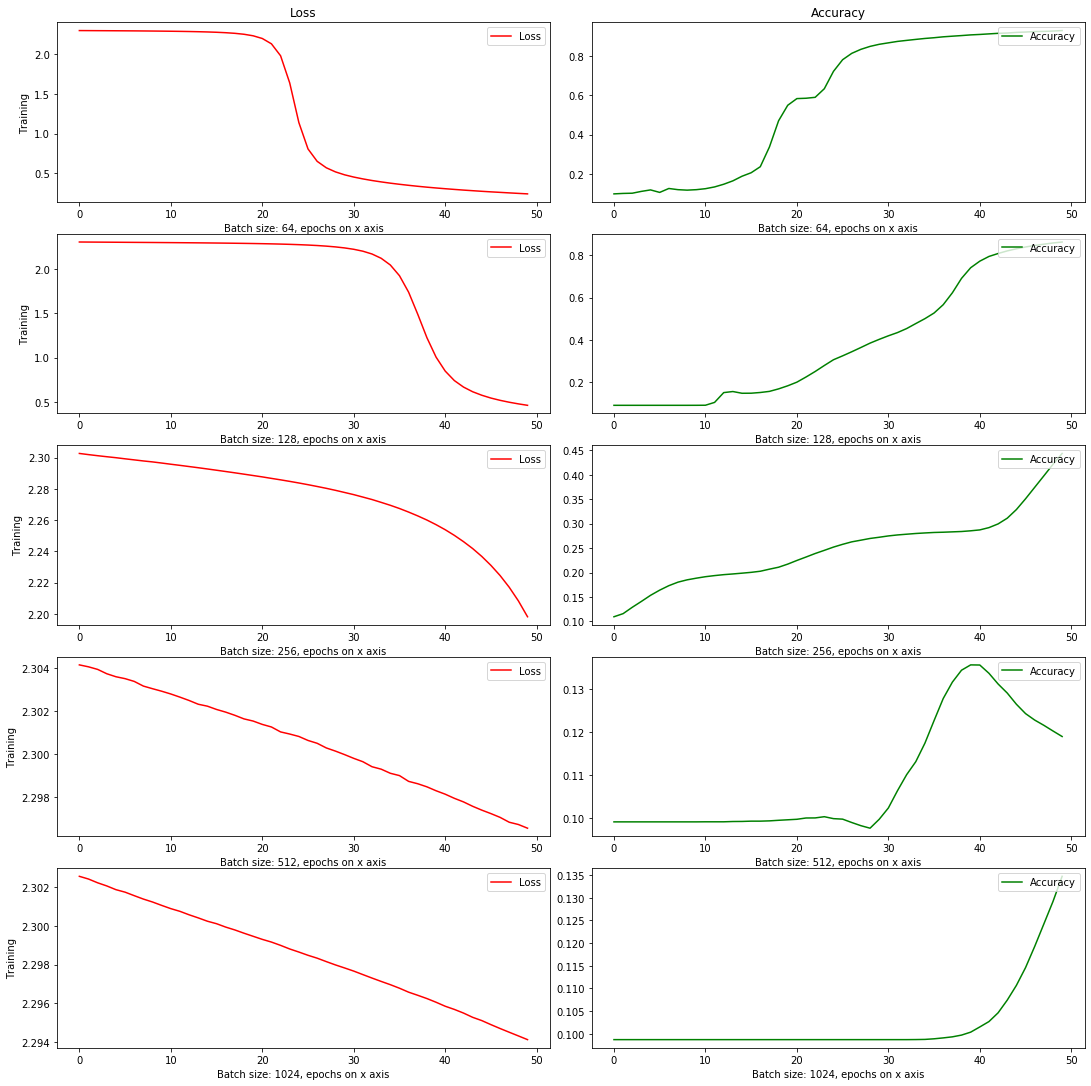

In [20]:
# Choosing different batch sizes to try
batch_sizes = [64, 128, 256, 512, 1024]
# subplots
f, axes = plt.subplots(len(batch_sizes), 2, figsize=(15,15))

cols = ['Loss', 'Accuracy']

# setting title for axes in subplots
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

f.tight_layout()
test_accuracies = []
# epochs
num_epochs = 50
# learning rate
learning_rate = 0.0005
for fig_num, batch_size in enumerate(batch_sizes):
    print(f"Batch size: {batch_size}")
    trainLoader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=4) # Creating dataloader

    # Validation set with random rotations in the range [-90,90]
    testLoader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4) # Creating dataloader
    net = LeNet()
    if use_gpu:
        net = net.cuda()
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)

    train_loss = []
    train_acc = []
    for epoch in range(num_epochs):

        running_loss = 0.0 
        running_corr = 0

        for i,data in enumerate(trainLoader):

            inputs,labels = data
            if use_gpu:
                inputs, labels = inputs.cuda(),labels.cuda() 
            # Initializing model gradients to zero
            # optimizer.zero_grad()
            net.zero_grad() 
            # Data feed-forward through the network
            outputs = net(inputs)
            # Predicted class is the one with maximum probability
            preds = torch.argmax(outputs,dim=1)
            # Finding the loss
            loss = criterion(outputs, labels)
            # Accumulating the loss for each batch
            running_loss += loss 
            # Accumulate number of correct predictions
            running_corr += torch.sum(preds==labels)  
            loss.backward()
            optimizer.step()

        
        epoch_loss = running_loss.item()/(i+1)   #Total loss for one epoch
        epoch_acc = running_corr.item()/60000



        train_loss.append(epoch_loss) #Saving the loss over epochs for plotting the graph
        train_acc.append(epoch_acc) #Saving the accuracy over epochs for plotting the graph


        print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(epoch+1,num_epochs,epoch_loss,epoch_acc*100))  
    # Plotting graphs for Batch size = batch_size in appropriate subplot
    axes[fig_num, 0].plot()
    axes[fig_num, 0].plot(range(num_epochs),train_loss,'r-',label='Loss') 
    axes[fig_num, 0].set_xlabel(f'Batch size: {batch_size}, epochs on x axis')
    axes[fig_num, 0].set_ylabel('Training')
    axes[fig_num, 1].plot(range(num_epochs),train_acc,'g-',label='Accuracy') 
    axes[fig_num, 1].set_xlabel(f'Batch size: {batch_size}, epochs on x axis')
    axes[fig_num, 0].legend(loc="upper right")
    axes[fig_num, 1].legend(loc="upper right")
    # Calculating testing accuracy
    correct_pred = 0
    for data in testLoader:
        inputs,labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(),labels.cuda()
        # Feedforward train data batch through model
        output = net(inputs) 
        # Predicted class is the one with maximum probability
        preds = torch.argmax(output,dim=1)
        correct_pred += torch.sum(preds==labels)

    test_accuracy = correct_pred.item()/10000.0
    print('Testing accuracy = ',test_accuracy*100)
    test_accuracies.append(test_accuracy*100)
plt.show()

Text(0, 0.5, 'Testing accuracy')

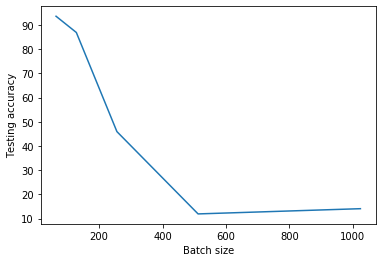

In [21]:
# Plotting testing_accuracy vs batch sizes
plt.plot(batch_sizes, test_accuracies)
plt.xlabel('Batch size')
plt.ylabel('Testing accuracy')

**Above all the plots has been plotted separately
Below is all the graphs in a single plot for better comparision**

Batch size: 64
Epoch 1/50 : Training loss: 2.3051 | Training Accuracy: 9.0350
Epoch 2/50 : Training loss: 2.3032 | Training Accuracy: 9.0350
Epoch 3/50 : Training loss: 2.3013 | Training Accuracy: 9.0350
Epoch 4/50 : Training loss: 2.2995 | Training Accuracy: 9.0350
Epoch 5/50 : Training loss: 2.2976 | Training Accuracy: 9.0800
Epoch 6/50 : Training loss: 2.2955 | Training Accuracy: 10.6533
Epoch 7/50 : Training loss: 2.2931 | Training Accuracy: 21.2950
Epoch 8/50 : Training loss: 2.2902 | Training Accuracy: 32.3700
Epoch 9/50 : Training loss: 2.2867 | Training Accuracy: 31.6600
Epoch 10/50 : Training loss: 2.2820 | Training Accuracy: 29.3817
Epoch 11/50 : Training loss: 2.2755 | Training Accuracy: 30.5483
Epoch 12/50 : Training loss: 2.2663 | Training Accuracy: 32.5833
Epoch 13/50 : Training loss: 2.2524 | Training Accuracy: 35.4967
Epoch 14/50 : Training loss: 2.2294 | Training Accuracy: 38.6567
Epoch 15/50 : Training loss: 2.1874 | Training Accuracy: 41.6350
Epoch 16/50 : Training l

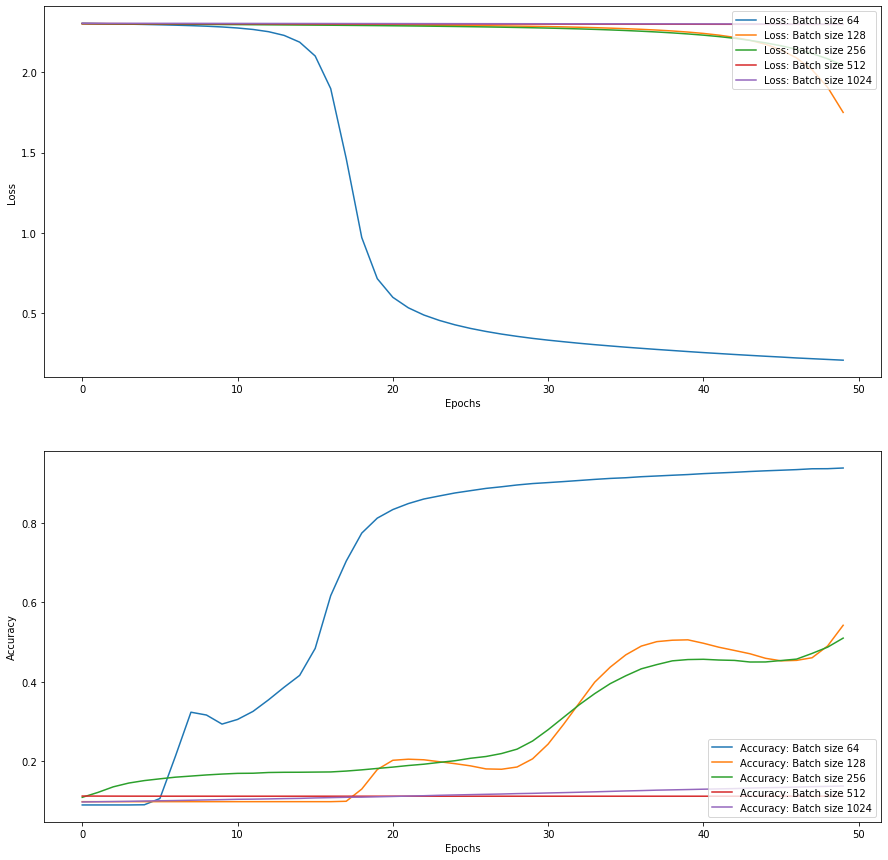

In [12]:
# Choosing different batch sizes to try
batch_sizes = [64, 128, 256, 512, 1024]

# Plots axes, size and labels
f, (ax1, ax2) = plt.subplots(2, figsize=(15, 15))
ax1.set_xlabel(f'Epochs')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
cols = ['Loss', 'Accuracy']

test_accuracies = []
num_epochs = 50
learning_rate = 0.005
for fig_num, batch_size in enumerate(batch_sizes):
    print(f"Batch size: {batch_size}" )
    trainLoader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=4) # Creating dataloader

    # Validation set with random rotations in the range [-90,90]
    testLoader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4) # Creating dataloader
    net = LeNet()
    if use_gpu:
        net = net.cuda()
    criterion = nn.CrossEntropyLoss() 
    learning_rate = 0.0005
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)

    train_loss = []
    train_acc = []
    for epoch in range(num_epochs):

        running_loss = 0.0 
        running_corr = 0

        for i,data in enumerate(trainLoader):

            inputs,labels = data
            if use_gpu:
                inputs, labels = inputs.cuda(),labels.cuda() 
            # Initializing model gradients to zero
            # optimizer.zero_grad()
            net.zero_grad() 
            # Data feed-forward through the network
            outputs = net(inputs)
            # Predicted class is the one with maximum probability
            preds = torch.argmax(outputs,dim=1)
            # Finding the loss
            loss = criterion(outputs, labels)
            # Accumulating the loss for each batch
            running_loss += loss 
            # Accumulate number of correct predictions
            running_corr += torch.sum(preds==labels)  
            loss.backward()
            optimizer.step()

        
        epoch_loss = running_loss.item()/(i+1)   #Total loss for one epoch
        epoch_acc = running_corr.item()/60000



        train_loss.append(epoch_loss) #Saving the loss over epochs for plotting the graph
        train_acc.append(epoch_acc) #Saving the accuracy over epochs for plotting the graph


        print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(epoch+1,num_epochs,epoch_loss,epoch_acc*100))  
    # Plotting with legends on the same axes ax1 and ax2
    ax1.plot(range(num_epochs),train_loss,label= f'Loss: Batch size {batch_size}') 
    ax2.plot(range(num_epochs),train_acc,label=f'Accuracy: Batch size {batch_size}') 
    ax1.legend(loc="upper right")
    ax2.legend(loc="lower right")
    correct_pred = 0
    
    # Calculating testing accuracy
    for data in testLoader:
        inputs,labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(),labels.cuda()
        # Feedforward train data batch through model
        output = net(inputs) 
        # Predicted class is the one with maximum probability
        preds = torch.argmax(output,dim=1)
        correct_pred += torch.sum(preds==labels)

    test_accuracy = correct_pred.item()/10000.0
    print('Testing accuracy = ',test_accuracy*100)
    test_accuracies.append(test_accuracy*100)
plt.show()

Less batch sizes looks good in SGD at least for this dataset

## Training Error/accuracy vs Epoch with different learning rate and fixed batch size

In [13]:
# batch size is very big from running previous cells
batch_size = 256
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=4) # Creating dataloader

# Validation set with random rotations in the range [-90,90]
testLoader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                     shuffle=False, num_workers=4) # Creating dataloader

Learning rate is 0.005
Epoch 1/50 : Training loss: 2.3048 | Training Accuracy: 9.9150
Epoch 2/50 : Training loss: 2.3030 | Training Accuracy: 9.9150
Epoch 3/50 : Training loss: 2.3015 | Training Accuracy: 9.9150
Epoch 4/50 : Training loss: 2.3001 | Training Accuracy: 9.9167
Epoch 5/50 : Training loss: 2.2986 | Training Accuracy: 12.2150
Epoch 6/50 : Training loss: 2.2969 | Training Accuracy: 18.8367
Epoch 7/50 : Training loss: 2.2947 | Training Accuracy: 12.3617
Epoch 8/50 : Training loss: 2.2918 | Training Accuracy: 12.5000
Epoch 9/50 : Training loss: 2.2873 | Training Accuracy: 16.0500
Epoch 10/50 : Training loss: 2.2795 | Training Accuracy: 20.4750
Epoch 11/50 : Training loss: 2.2645 | Training Accuracy: 27.6350
Epoch 12/50 : Training loss: 2.2263 | Training Accuracy: 36.8450
Epoch 13/50 : Training loss: 2.0679 | Training Accuracy: 43.4000
Epoch 14/50 : Training loss: 1.3297 | Training Accuracy: 66.0250
Epoch 15/50 : Training loss: 0.6828 | Training Accuracy: 80.4883
Epoch 16/50 : T

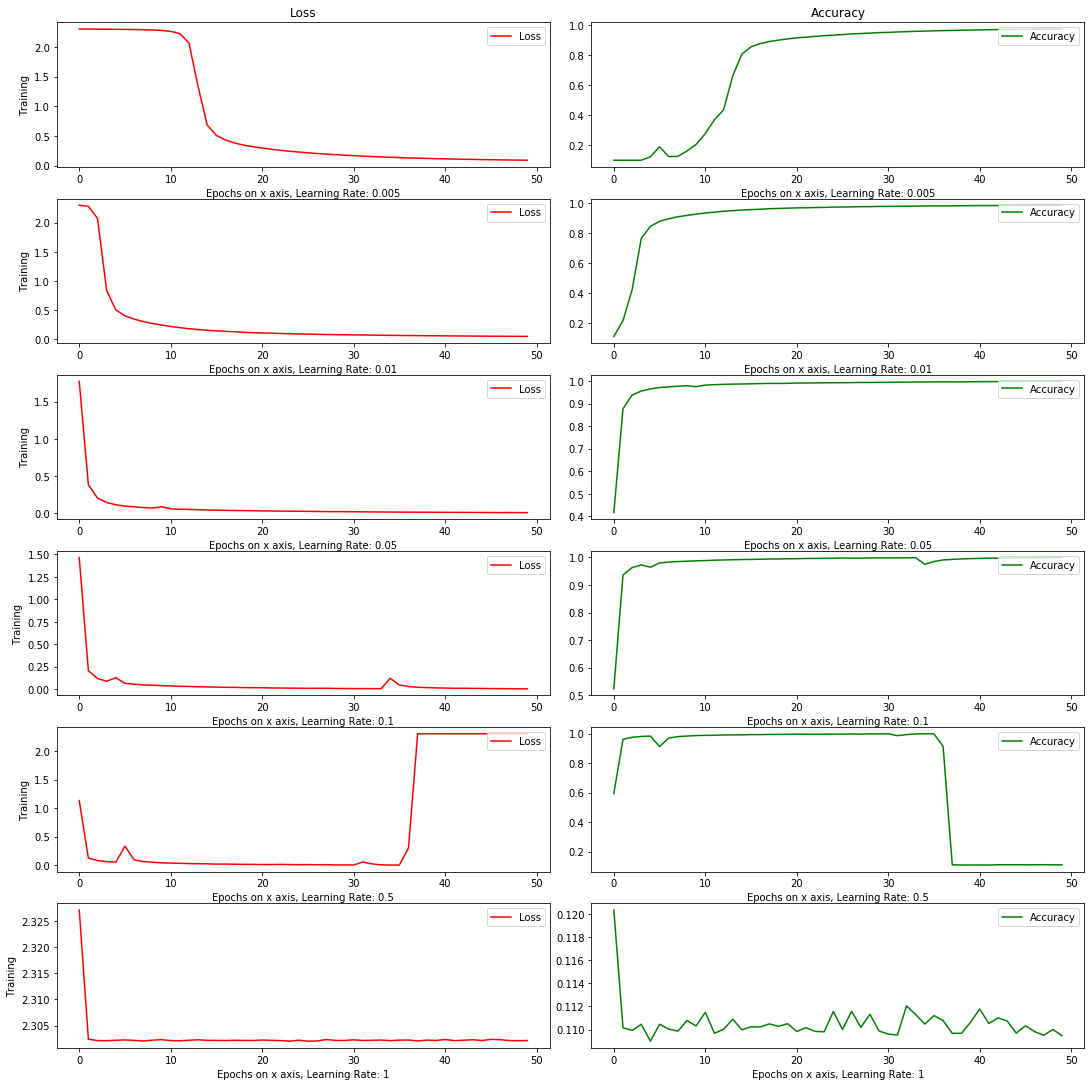

In [18]:
# Choosing different learning rates to try
learning_rates = [5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1]

# axes for plots, rows, cols, figure size 
f, axes = plt.subplots(len(learning_rates), 2, figsize=(15,15))

cols = ['Loss', 'Accuracy']


for ax, col in zip(axes[0], cols):
    ax.set_title(col)

f.tight_layout()

# For storing testing accuracies
test_accuracies = []
num_epochs = 50

for fig_num, learning_rate in enumerate(learning_rates):
    print(f"Learning rate is {learning_rate}")
    net = LeNet()
    if use_gpu:
        net = net.cuda()
    # Using cross entropy loss
    criterion = nn.CrossEntropyLoss()
    # Using SGC optimizer
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    
    # storing training loss and accuracies to plot
    train_loss = []
    train_acc = []
    for epoch in range(num_epochs):
        
        running_loss = 0.0 
        running_corr = 0

        for i,data in enumerate(trainLoader):

            inputs,labels = data
            if use_gpu:
                inputs, labels = inputs.cuda(),labels.cuda() 
            # Initializing model gradients to zero
            # optimizer.zero_grad()
            net.zero_grad() 
            # Data feed-forward through the network
            outputs = net(inputs)
            # Predicted class is the one with maximum probability
            preds = torch.argmax(outputs,dim=1)
            # Finding the loss
            loss = criterion(outputs, labels)
            # Accumulating the loss for each batch
            running_loss += loss 
            # Accumulate number of correct predictions
            running_corr += torch.sum(preds==labels)  
            loss.backward()
            optimizer.step()

        
        epoch_loss = running_loss.item()/(i+1)   #Total loss for one epoch
        epoch_acc = running_corr.item()/60000



        train_loss.append(epoch_loss) #Saving the loss over epochs for plotting the graph
        train_acc.append(epoch_acc) #Saving the accuracy over epochs for plotting the graph


        print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(epoch+1,num_epochs,epoch_loss,epoch_acc*100))  
    # Plotting on appropriate axes with legends and axes titles
    axes[fig_num, 0].plot()
    axes[fig_num, 0].plot(range(num_epochs),train_loss,'r-',label='Loss') 
    axes[fig_num, 0].set_xlabel(f'Epochs on x axis, Learning Rate: {learning_rate}')
    axes[fig_num, 0].set_ylabel('Training')
    axes[fig_num, 1].plot(range(num_epochs),train_acc,'g-',label='Accuracy') 
    axes[fig_num, 1].set_xlabel(f'Epochs on x axis, Learning Rate: {learning_rate}')
    axes[fig_num, 0].legend(loc="upper right")
    axes[fig_num, 1].legend(loc="upper right")

    correct_pred = 0
    for data in testLoader:
        inputs,labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(),labels.cuda()
        # Feedforward train data batch through model
        output = net(inputs) 
        # Predicted class is the one with maximum probability
        preds = torch.argmax(output,dim=1)
        correct_pred += torch.sum(preds==labels)

    test_accuracy = correct_pred.item()/10000.0
    print('Testing accuracy = ',test_accuracy*100)
    test_accuracies.append(test_accuracy*100)
plt.show()

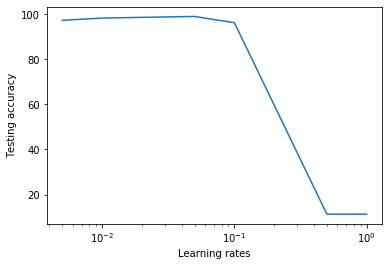

In [15]:
# Plotting testing accuracies with learning rates
plt.plot(learning_rates, test_accuracies)
plt.xlabel('Learning rates')
plt.ylabel('Testing accuracy')
ax = plt.gca()
# Set x logaritmic
ax.set_xscale('log')

Very high learning rates results in very bad testing accuracy

**Above all the plots has been plotted separately, 
below is all the graphs in a single plot for better comparision**

Learning rate is 0.005
Epoch 1/50 : Training loss: 2.3028 | Training Accuracy: 10.2183
Epoch 2/50 : Training loss: 2.2969 | Training Accuracy: 10.9783
Epoch 3/50 : Training loss: 2.2891 | Training Accuracy: 26.0850
Epoch 4/50 : Training loss: 2.2756 | Training Accuracy: 37.3233
Epoch 5/50 : Training loss: 2.2395 | Training Accuracy: 37.9367
Epoch 6/50 : Training loss: 2.0417 | Training Accuracy: 47.5150
Epoch 7/50 : Training loss: 1.1723 | Training Accuracy: 69.7217
Epoch 8/50 : Training loss: 0.6546 | Training Accuracy: 80.6600
Epoch 9/50 : Training loss: 0.5167 | Training Accuracy: 84.7217
Epoch 10/50 : Training loss: 0.4446 | Training Accuracy: 86.7083
Epoch 11/50 : Training loss: 0.3989 | Training Accuracy: 88.2167
Epoch 12/50 : Training loss: 0.3657 | Training Accuracy: 89.0083
Epoch 13/50 : Training loss: 0.3387 | Training Accuracy: 89.7233
Epoch 14/50 : Training loss: 0.3186 | Training Accuracy: 90.2900
Epoch 15/50 : Training loss: 0.2990 | Training Accuracy: 90.9450
Epoch 16/50

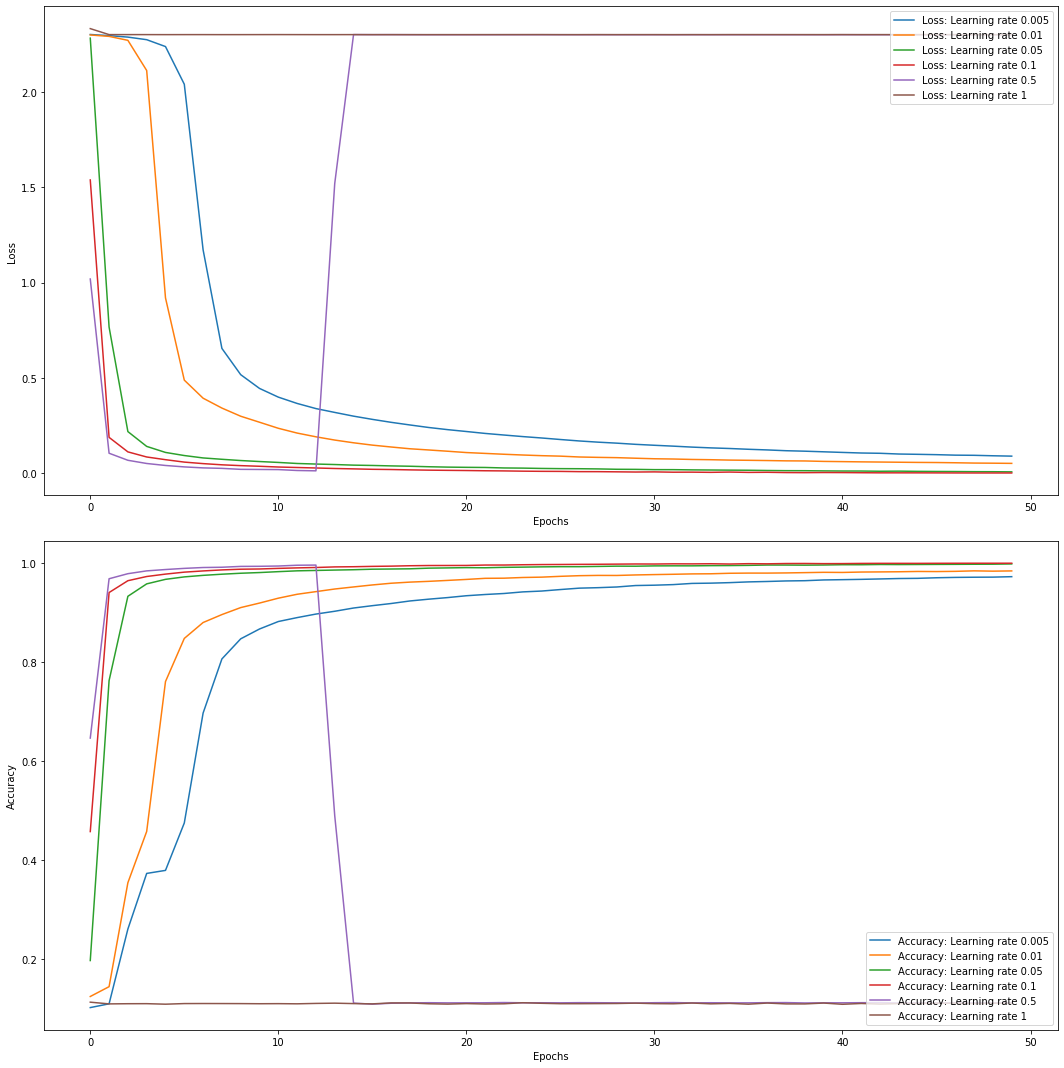

In [16]:
# Choosing different learning rates to try
learning_rates = [5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1]

# Plots axes, size and labels
f, (ax1, ax2) = plt.subplots(2, figsize=(15, 15))
ax1.set_xlabel(f'Epochs')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

cols = ['Loss', 'Accuracy']

# Setting axis title
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

f.tight_layout()

# storing test accuracies
test_accuracies = []
num_epochs = 50

for fig_num, learning_rate in enumerate(learning_rates):
    print(f"Learning rate is {learning_rate}")
    net = LeNet()
    if use_gpu:
        net = net.cuda()
        
    # Using Cross Entropy Loss and SGD Optimizer
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)

    train_loss = []
    train_acc = []
    for epoch in range(num_epochs):

        running_loss = 0.0 
        running_corr = 0

        for i,data in enumerate(trainLoader):

            inputs,labels = data
            if use_gpu:
                inputs, labels = inputs.cuda(),labels.cuda() 
            # Initializing model gradients to zero
            # optimizer.zero_grad()
            net.zero_grad() 
            # Data feed-forward through the network
            outputs = net(inputs)
            # Predicted class is the one with maximum probability
            preds = torch.argmax(outputs,dim=1)
            # Finding the loss
            loss = criterion(outputs, labels)
            # Accumulating the loss for each batch
            running_loss += loss 
            # Accumulate number of correct predictions
            running_corr += torch.sum(preds==labels)  
            loss.backward()
            optimizer.step()

        
        epoch_loss = running_loss.item()/(i+1)   #Total loss for one epoch
        epoch_acc = running_corr.item()/60000



        train_loss.append(epoch_loss) #Saving the loss over epochs for plotting the graph
        train_acc.append(epoch_acc) #Saving the accuracy over epochs for plotting the graph


        print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(epoch+1,num_epochs,epoch_loss,epoch_acc*100))  
    # Plotting with legends on the same axes ax1 and ax2
    ax1.plot(range(num_epochs),train_loss,label= f'Loss: Learning rate {learning_rate}') 
    ax2.plot(range(num_epochs),train_acc,label=f'Accuracy: Learning rate {learning_rate}') 
    ax1.legend(loc="upper right")
    ax2.legend(loc="lower right")

    # Calculating testing accuracy
    correct_pred = 0
    for data in testLoader:
        inputs,labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(),labels.cuda()
        # Feedforward train data batch through model
        output = net(inputs) 
        # Predicted class is the one with maximum probability
        preds = torch.argmax(output,dim=1)
        correct_pred += torch.sum(preds==labels)

    test_accuracy = correct_pred.item()/10000.0
    print('Testing accuracy = ',test_accuracy*100)
    test_accuracies.append(test_accuracy*100)
plt.show()

Best accuracy is for learning rate 0.1

Helpful web links:  
* [Difference between model.zero_grad() and optimizer.zero_grad()](https://discuss.pytorch.org/t/model-zero-grad-or-optimizer-zero-grad/28426/4)
  * Essentially both are same if you give all the model parameters into optimizers.
* [Subplots in matplotlib](https://stackoverflow.com/questions/31726643/how-do-i-get-multiple-subplots-in-matplotlib)
  
```python
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(2, 2)

    ax[0, 0].plot(range(10), 'r') #row=0, col=0
    ax[1, 0].plot(range(10), 'b') #row=1, col=0
    ax[0, 1].plot(range(10), 'g') #row=0, col=1
    ax[1, 1].plot(range(10), 'k') #row=1, col=1
    plt.show()
```

* [Giving axis labels to subplots](https://stackoverflow.com/questions/38662667/matplotlib-and-subplots-properties)

```python
ax = plt.subplot('111')
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
```

* [Row and column headers in subplots](https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots)

```python
import matplotlib.pyplot as plt

cols = ['Column {}'.format(col) for col in range(1, 4)]
rows = ['Row {}'.format(row) for row in ['A', 'B', 'C', 'D']]

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8))

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')

fig.tight_layout()
plt.show()
```
  
* [Legends in subplots](https://stackoverflow.com/questions/27016904/matplotlib-legends-in-subplot)  

```python
f, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(xtr, color='r', label='HHZ 1')
ax1.legend(loc="upper right")
ax2.plot(xtr, color='r', label='HHN')
ax2.legend(loc="upper right")
ax3.plot(xtr, color='r', label='HHE')
ax3.legend(loc="upper right")  
```

* [Changing scale of one axis in matplotlib](https://stackoverflow.com/questions/26198260/how-can-i-exponentially-scale-the-y-axis-with-matplotlib)

* [Gradeint Descent vs Stochastic Gradient Descent](https://stats.stackexchange.com/questions/49528/batch-gradient-descent-versus-stochastic-gradient-descent)

The applicability of batch or stochastic gradient descent really depends on the error manifold expected.

Batch gradient descent computes the gradient using the whole dataset. This is great for convex, or relatively smooth error manifolds. In this case, we move somewhat directly towards an optimum solution, either local or global. Additionally, batch gradient descent, given an annealed learning rate, will eventually find the minimum located in it's basin of attraction.

Stochastic gradient descent (SGD) computes the gradient using a single sample. Most applications of SGD actually use a minibatch of several samples, for reasons that will be explained a bit later. SGD works well (Not well, I suppose, but better than batch gradient descent) for error manifolds that have lots of local maxima/minima. In this case, the somewhat noisier gradient calculated using the reduced number of samples tends to jerk the model out of local minima into a region that hopefully is more optimal. Single samples are really noisy, while minibatches tend to average a little of the noise out. Thus, the amount of jerk is reduced when using minibatches. A good balance is struck when the minibatch size is small enough to avoid some of the poor local minima, but large enough that it doesn't avoid the global minima or better-performing local minima. (Incidently, this assumes that the best minima have a larger and deeper basin of attraction, and are therefore easier to fall into.)

One benefit of SGD is that it's computationally a whole lot faster. Large datasets often can't be held in RAM, which makes vectorization much less efficient. Rather, each sample or batch of samples must be loaded, worked with, the results stored, and so on. Minibatch SGD, on the other hand, is usually intentionally made small enough to be computationally tractable.

Usually, this computational advantage is leveraged by performing many more iterations of SGD, making many more steps than conventional batch gradient descent. This usually results in a model that is very close to that which would be found via batch gradient descent, or better.

The way I like to think of how SGD works is to imagine that I have one point that represents my input distribution. My model is attempting to learn that input distribution. Surrounding the input distribution is a shaded area that represents the input distributions of all of the possible minibatches I could sample. It's usually a fair assumption that the minibatch input distributions are close in proximity to the true input distribution. Batch gradient descent, at all steps, takes the steepest route to reach the true input distribution. SGD, on the other hand, chooses a random point within the shaded area, and takes the steepest route towards this point. At each iteration, though, it chooses a new point. The average of all of these steps will approximate the true input distribution, usually quite well.

* [Gradient Descent, Stochastic Gradient Descent and Batch Stochastic Gradient Descent](https://datascience.stackexchange.com/questions/27421/when-are-weights-updated-in-cnn)

### Visualizing images

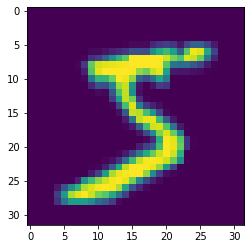

In [19]:
plt.imshow(trainset[0][0][0, :, :])